# Using an auto encoder on MNIST handwritten digits.

In [29]:
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from utils import get_mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


In [30]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)
train_data = train_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))
test_data = test_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))

print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


In [31]:
# Parameters
training_epochs = 10
batch_size = 128
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden = 32
n_input = 784 # MNIST data input (img shape: 28*28)

In [32]:
# Create Model

def build_autoencoder(n_input, n_hidden):
    # Initialize a sequential container
    model = Sequential()

    # encoder
    model.add(Linear(n_input, n_hidden))
    model.add(ReLU())
    # decoder
    model.add(Linear(n_hidden, n_input))
    model.add(Sigmoid())
    
    return model
model = build_autoencoder(n_input, n_hidden)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [33]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=MSECriterion(),
    optim_method=Adam(),
    end_trigger=MaxEpoch(2),
    batch_size=batch_size)


app_name='autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)


optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createTrainSummary
saving logs to  autoencoder-20171025-111944


In [34]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 6.75 ms, sys: 2.54 ms, total: 9.3 ms
Wall time: 34.5 s


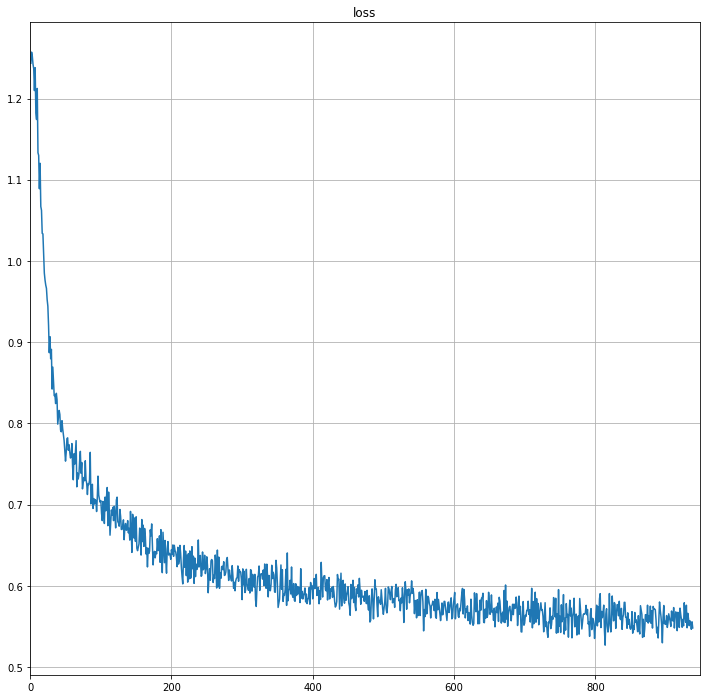

In [35]:
loss = np.array(train_summary.read_scalar("Loss"))
lr = np.array(train_summary.read_scalar("LearningRate"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')


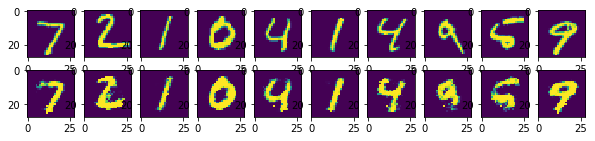

In [36]:
(images, labels) = mnist.read_data_sets(mnist_path, "test")
examples = trained_model.predict(test_data).take(10)
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(images[i], (28, 28)))
    a[1][i].imshow(np.reshape(examples[i], (28, 28)))